# Sesión 7

## introducción a PyMC

![](../images/sesion7-PyMC.jpg)

Hasta ahora hemos trabajado con modelos bayesianos básicos utilizando un enfoque de _inferencia exacta_. Sin embargo, vimos que este enfoque presenta limitaciones importantes y no es aplicable en algunnos de los casos reales.

Por ello, introdujimos los **métodos de muestreo**, que nos permiten realizar inferencia aproximada sobre la _distribución posterior_.

En este módulo aprenderemos a utilizar la _API de la librería_ ``PyMC``, una herramienta que facilita la construcción y el ajuste de modelos bayesianos. Gracias a ``PyMC``, podremos centrarnos en el **modelado estadístico** sin preocuparnos tanto por los detalles técnicos de los métodos de inferencia subyacentes.

> **Objetivos:**
> - Estudiar la API de `PyMC`, en particular las funciones para crear modelos, definir variables aleatorias previas y verosimilitudes, hacer inferencia y el muestreo de la distribución posterior predictiva.

> **Referencias:**
> - https://www.pymc.io/welcome.html#get-started

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pymc as pm

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
az.style.use("arviz-darkgrid")

### 1. Creación de modelos

En **PyMC**, los modelos se definen utilizando la clase `Model`.

Dentro de esta clase se especifican todas las **variables aleatorias** y sus **relaciones**, mientras que `Model` se encarga de calcular automáticamente la **log-probabilidad** del modelo y sus **gradientes** (necesarios, por ejemplo, para el algoritmo **MCMC**, **HMC** o **NUTS**).

Usualmente, se utiliza un **administrador de contexto** para crear una instancia del modelo de forma clara y ordenada:

In [4]:
# Instanciamos el modelo
with pm.Model() as model:
    #Aquí van las variables aleatorias y sus relaciones
    pass

Dentro del modelo, se definen las variables aleatorias necesarias:

Retomando el [ejemplo 6](M1-sesion6-PT2.ipynb#Todo-continuo:-previas-continuas,-verosimilitudes-continuas) de la [sesión 6](M1-sesion6-PT2.ipynb), definamos el mismo problema ahora utilizando la librería `PyMC`.

* **Nivel 1: Datos**
Supongamos que tenemos un dato $x=5$ que obtuvimos de una distribución normal con media $\theta$ y varianza $1$:

$$ x \sim \mathcal{N}(\theta, 1)$$

* **Nivel 2: Parámetro desconocido**
Supongamo que nuestra _previa_ para el parámetro $\theta$ es también una normal:

$$ \theta \sim \mathcal{N}(2,1)$$

En la sesión 6 vimos que pudimos llegar a la solución analítica; sin embargo, ahora vamos a definir el mismo modelo pero con **programación probabilística**:

In [5]:
# Modelo básico: verosimilitud normal con varianza conocida, previa normal
with pm.Model() as model:

    # Previa
    theta = pm.Normal("theta",
                      mu=2,
                      sigma=1)
    # Verosimilitud
    x = pm.Normal("x",
                  mu=theta,
                  sigma=1,
                  observed=[5])


* **Variables aleatorias**

In [6]:
# Inspección: ¿qué variables aleatorias tiene el modelo?
model.basic_RVs

[theta ~ Normal(2, 1), x ~ Normal(theta, 1)]

* **Variables aleatorias libres** _(que no dependen de otras variables aleatorias)_

In [7]:
# Inspección: ¿qué variables aleatorias libres tiene el modelo?
model.free_RVs

[theta ~ Normal(2, 1)]

* **Variables alatorias observadas** _(que dependen de otras variables aleatorias y tienen datos asociados)_

In [8]:
# Inspección de las variables aleatorias observadas
model.observed_RVs

[x ~ Normal(theta, 1)]

* **Compilar $logp$ de la posterior**

In [9]:
# Cálculo de logp
model.compile_logp()({"theta": 0})

array(-16.33787707)

* **Compilar derivada de $logp$ de la posterior**

In [10]:
model.compile_dlogp()({"theta": 0})

array([7.])

```{admonition} Monte Carlo Hamiltoniano (HMC)
:class: tip

Una de las formas en que funcionan internamente estos motores de inferencia es mediante un método llamado **Monte Carlo Hamiltoniano (HMC)**.

Este algoritmo necesita tanto el valor de la **log-probabilidad** de la posterior (`logp`) como su **derivada** (el **gradiente de la log-probabilidad**, `dlogp`).

De manera intuitiva, HMC utiliza `logp` para saber **qué tan probable** es una combinación de parámetros, y `dlogp` para saber **hacia qué dirección aumenta esa probabilidad**.

Con esta información, el método puede **moverse con mayor inteligencia** por el espacio de parámetros, avanzando hacia las regiones más probables y explorándolas de forma eficiente, en lugar de hacerlo al azar como otros métodos MCMC más simples.
```

## 2. Distribuciones de probabilidad

Todo programa probabilístico está compuesto por **variables aleatorias observadas** y **no observadas**.

- Las **variables observadas** (verosimilitud) se definen mediante **distribuciones de verosimilitud**, que representan la probabilidad de los datos dados los parámetros del modelo — es decir, $p(\text{datos} \mid \text{parámetros})$.

- Las **variables no observadas** (o latentes) se definen mediante **distribuciones previas**, que expresan nuestras creencias sobre los parámetros antes de ver los datos.

Puedes consultar el catálogo completo de distribuciones disponibles en PyMC en la [documentación oficial](https://www.pymc.io/projects/docs/en/stable/api/distributions.html#api-distributions).

### Variables aleatorias no observadas

Las **variables aleatorias no observadas** se definen especificando:

- `name`: un nombre para la variable (tipo `str`),
- los parámetros de la distribución (pasados como argumentos con nombre).

Por ejemplo, para definir una variable con distribución **Normal**:

In [11]:
# Variable aleatoria normal x no observada (previa)

with pm.Model():
    x = pm.Normal("x", #el nombre de la variable (un texto que la identifica)
                  mu=0,
                  sigma=1)

### Variables aleatorias observadas

Las **variables aleatorias observadas** se definen de forma similar a las no observadas,  
pero además requieren que se especifiquen los **datos observados** mediante el argumento `observed`.

Este tipo de variables representan la **verosimilitud** del modelo, es decir, la distribución que describe cómo se generan los datos a partir de los parámetros.

In [12]:
# Variable aleatoria normal x observada (verosimilitud)

with pm.Model():
    x = pm.Normal("x", #el nombre de la variable (un texto que la identifica)
                  mu=0,
                  sigma=1,
                  observed=rng.normal(0, 1, 100))

En este caso, ``x`` representa una distribución Normal con media ``0`` y desviación estándar ``1`` y los 100 valores generados aleatoriamente se pasan como los ``datos observados``.

> `observed` en el caso anterior, es un array de 100 valores generados aleatoriamente a partir de una distribución normal con media 0 y desviación estándar 1. En casos reales, este array contendría los datos que hemos observado y queremos modelar; casi siempre es un array o lista de datos.

> Ejemplo:
> Supón que tenemos datos reales de alturas (en metros)
> ```python
> datos_alturas = pd.Series([1.68, 1.75, 1.80, 1.60, 1.72, 1.78, 1.69])
>
> with pm.Model():
>     x = pm.Normal(
>         "x",
>         mu=1.70,          # suposición sobre la media
>         sigma=0.1,        # suposición sobre la desviación estándar
>         observed=datos_alturas  # aquí van los datos reales
>     )

### Transformaciones deterministas

Hasta ahora hemos trabajado con **variables aleatorias**, es decir, cantidades que tienen incertidumbre y siguen una distribución (por ejemplo, una Normal o una Gamma).

Pero en PyMC también podemos crear **nuevas variables** que se calculan **a partir de otras**, usando operaciones matemáticas.

Estas se llaman **transformaciones deterministas**, porque **no introducen más azar**: su valor depende completamente de otras variables.

> *¿qué significa "determinista"?*
>
> Una transformación determinista es simplemente una **relación matemática fija** entre variables.
>
> Por ejemplo, si tenemos dos variables aleatorias $x$ y $y$:
>
> - Podemos definir una nueva variable como $x + y$
>- O aplicar una función matemática como $\sin(x)$ o $x^2$
>
> En todos esos casos, el valor de la nueva variable **no es aleatorio por sí mismo**, sino que **se calcula** en función de las variables que sí lo son.

In [13]:
# Variables aleatorias no observadas x e y transformaciones deterministas
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    # x + 2
    plus_2 = x + 2
    # x + y
    sum_x_y = x + y
    # x ** 2
    squared = x ** 2
    # sin(x)
    sin_x = pm.math.sin(x)

Si queremos que PyMC registre y guarde los valores de estas transformaciones (por ejemplo, para analizarlas después del muestreo), debemos usar `pm.Deterministic`:

In [14]:
# Uso de deterministic
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    # x + 2
    plus_2 = pm.Deterministic("plus_2", x + 2)
    # x + y
    sum_x_y = pm.Deterministic("sum_x_y", x + y)
    # x ** 2
    squared = pm.Deterministic("squared", x ** 2)
    # sin(x)
    sin_x = pm.Deterministic("sin_x", pm.math.sin(x))

### Variables aleatorias de alto orden

Hasta ahora hemos trabajado con variables aleatorias **unidimensionales** (escalares), es decir, aquellas que representan un solo valor aleatorio.

Sin embargo, en muchos modelos estadísticos queremos representar **colecciones de variables relacionadas**, como parámetros para distintas ciudades, grupos o individuos.

Por ejemplo, podríamos tener una media diferente para cada ciudad, o una desviación distinta para cada grupo experimental.

> La mejor práctica en PyMC para crear variables aleatorias de **múltiples dimensiones** es usar los argumentos `dims` y `coords`.
>
> - `coords` permite **nombrar las dimensiones** del modelo (por ejemplo, “ciudades”, “individuos”, “grupos”).
> - `dims` indica **a qué dimensión pertenece** cada variable aleatoria.
>
>Esto ayuda a que el modelo sea más **legible, estructurado y fácil de interpretar**.

In [15]:
# Coordenadas por ciudad
coords = {"cities": ["Santiago", "Mumbai", "Tokyo"]}

# Modelo con múltiples variables aleatorias asociadas a las ciudades
with pm.Model(coords=coords) as model:
    
    x = pm.Normal("x", # Previa normal por ciudad
                  mu=0,
                  sigma=1,
                  dims="cities")

Aquí, `x` ya no es una sola v.a., sino un vector de tres variables normales una por cada ciudad:

In [16]:
# Shape de las variables aleatorias
model.eval_rv_shapes()

{'x': (np.int64(3),)}

Matemáticamente, podríamos pensar en $x$ como un vector:

$$
x = [x_{\text{Santiago}},\ x_{\text{Mumbai}},\ x_{\text{Tokyo}}]
$$

donde cada componente $x_i$ sigue una distribución normal con media $0$ y desviación estándar $1$:

$$
x_i \sim \mathcal{N}(0, 1)
$$

## 3. Inferencia

Una vez definido nuestro modelo, el siguiente paso es aplicar **inferencia bayesiana** para aproximar la **distribución posterior** de los parámetros.

* **El problema**

Para calcular $P(y)$ tendríamos que resolver una integral como esta:

$$
P(y) = \int P(y \mid \theta) \, P(\theta) \, d\theta
$$

Esa integral suele ser **imposible de calcular de forma analítica** cuando el modelo es complejo o tiene muchos parámetros.

* **Muestreo: La idea clave**

Cuando hacemos **inferencia bayesiana** queremos conocer la _distribución posterior_ de los parámetros:

$$
P(\theta \mid y) = \frac{P(y \mid \theta) \, P(\theta)}{P(y)}
$$

En lugar de intentar calcular toda la función posterior, usamos **métodos de muestreo** para aproximarla.

En vez de calcular $P(\theta \mid y)$ directamente, generamos muchas muestras $\theta^{(1)}, \theta^{(2)}, \ldots, \theta^{(N)}$ que siguen la misma distribución que la posterior.

* **¿Cómo lo logramos generar las muestras?**

Aquí entran los métodos **MCMC (Markov Chain Monte Carlo)**, técnicas que generan muestras secuenciales, donde cada nuevo valor depende del anterior, pero de tal forma que, al cabo de muchas iteraciones, las muestras se distribuyen según la **posterior**.

### Muestreo MCMC en PyMC

* Función principal: **``pm.sample()``**

El punto de entrada principal a los algoritmos de muestreo MCMC en PyMC. Por defecto, selecciona automáticamente el muestreador más adecuado, generalmente NUTS (No-U-Turn Sampler), una versión del HMC (Hamiltonian Monte Carlo).

* **¿Qué hace ``pm.sample()``?**

Ejecuta un algoritmo MCMC (como NUTS) que genera una **cadena de valores de los parámetros**; esta cadena está construida de modo que, tras la convergencia, las muestras siguen la distribución posterior del modelo, permitiendo aproximarla sin calcularla de forma analítica.

![](../images/sesion7-sampling.png)

**Figura 1:** Proceso de muestreo MCMC. _Uploaded a work by Jaewook Lee Woosuk Sung Joo-Ho Choi from Metamodel for Efficient Estimation of Capacity-Fade Uncertainty in Li-Ion Batteries for Electric Vehicles June 2015Energies 8(6):5538-5554 DOI:10.3390/en8065538_

**¿qué ocurre internamente?**

PyMC inicia varias cadenas de Markov, cada una comenzando en un punto diferente del espacio de parámetros.

En cada iteración, cada cadena:

1. Propone un nuevo valor del parámetro (un pequeño "salto").
2. Evalúa qué tan probable es ese valor según la **verosimilitud** y la **previa**.
3. Acepta o rechaza el nuevo valor, de forma que las zonas con mayor probabilidad se visitan más a menudo.

![](../images/sesion7-sampling2.png)

**Figura 2:** Ilustración del proceso de muestreo en el algoritmo Metropolis–Hastings. _Fuente: Vasileios Zografos (2007). Imagen transferida de [English Wikipedia](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) a Wikimedia Commons. Licencia: **CC BY-SA 3.0**. Autor original: *Vzografos*._

In [17]:
# Modelo 
with pm.Model() as model:
    
    theta = pm.Normal("theta",
                       mu=2,
                       sigma=1) # Previa

    x = pm.Normal("x",
                   mu=theta,
                   sigma=1,
                   observed=[5]) # Verosimilitud

    # Muestreo
    idata = pm.sample(draws=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


* **``idata``: el resultado del muestreo**

El resultado del muestreo con `pm.sample()` es un objeto de tipo `InferenceData`, comúnmente almacenado en una variable llamada `idata`.

Este objeto contiene **toda la información generada durante el muestreo**.

Por ejemplo, si usamos 4 cadenas y cada una genera 2000 muestras,  
en total tendremos **8 000 muestras de la distribución posterior**.

En cada cadena se almacenan los valores que el muestreador fue aceptando para los parámetros. Así, para nuestro parámetro $\theta$, `idata.posterior["theta"]` será una matriz con forma:

$$
(4 \text{ cadenas}) \times (2000 \text{ muestras por cadena})
$$


In [18]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [19]:
# Dimensiones de las posteriores
idata.posterior.dims

FrozenMappingWarningOnValuesAccess({'chain': 4, 'draw': 2000})

In [20]:
# Para mu, shape
idata.posterior["theta"].shape

(4, 2000)

Podemos analizar una cadena específica o combinar todas las cadenas para estudiar la posterior completa.

En la práctica, lo habitual es usar todas las cadenas, ya que juntas ofrecen una mejor estimación de la distribución posterior.

In [21]:
# Para mu, cadena 2, shape
idata.posterior["theta"].sel(chain=2).shape

(2000,)

* **``plot_trace``: visualización las cadenas y la distribución posterior**

La función `az.plot_trace()` de ArviZ permite visualizar las _trazas_ (los valores muestreados a lo largo de las iteraciones) y la **distribución posterior** estimada para cada parámetro.

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

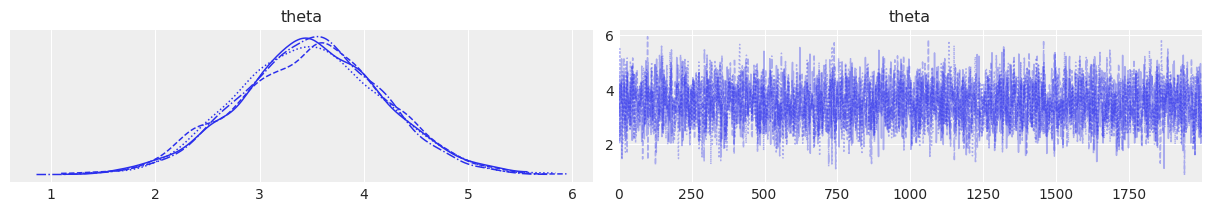

In [22]:
# plot_trace
az.plot_trace(idata)

> El gráfico que obtenemos muestra dos partes por cada parámetro (en este caso $\theta$):
> * **Izquierda:** el histograma y la densidad de las muestras, que representan la distribución posterior estimada.
> * **Derecha:** la traza o evolución de los valores muestreados en cada iteración (por todas las cadenas de Markov).
>
> Si las cadenas se observan sin tendencias ni patrones persistentes, eso indica que la simulación ha convergido y que estamos muestreando correctamente la distribución posterior.

* ``az.summary``: **Resumen estadístico**

También podemos obtener información de forma tabular:

In [23]:
az.summary(idata, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,3.491,0.703,2.333,4.576,0.012,0.007,3472.0,5708.0,1.0


| Columna | Significado |
|----------|-------------|
| **mean** | La **media posterior** de las muestras. Representa el valor esperado de $\theta$ según la distribución posterior. |
| **sd** | Desviación estándar de las muestras. Indica la **incertidumbre** de la estimación. |
| **hdi_5.5%** / **hdi_94.5%** | Límites inferior y superior del **Intervalo de Densidad Máxima (HDI)** al 89% (definido por `hdi_prob=0.89`). Es el rango dentro del cual se concentra el 89% más probable de los valores de $\theta$. |
| **mcse_mean** | Error estándar Monte Carlo de la media. Mide la **precisión** de la estimación de la media a partir del número de muestras. Cuanto más pequeño, mejor. |
| **mcse_sd** | Error estándar Monte Carlo de la desviación. Igual que el anterior, pero aplicado a la estimación de la dispersión. |
| **ess_bulk** | Tamaño efectivo de muestra (Effective Sample Size) en la región central de la distribución. Cuanto mayor, más confiables las estimaciones. |
| **ess_tail** | Tamaño efectivo de muestra en las colas de la distribución (valores extremos). Indica qué tan bien se exploraron los extremos. |
| **r_hat** | Estadístico de **convergencia de Gelman–Rubin**. Si está cercano a **1.0**, las cadenas han convergido correctamente. Valores mayores a 1.1 indican falta de convergencia. |

* **Diagramas `az.plot_forest`** 

Los diagramas tipo _forest_ son una forma compacta y visual de mostrar los **intervalos de credibilidad** (o **HDI**, *Highest Density Interval*) de la distribución posterior.

array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

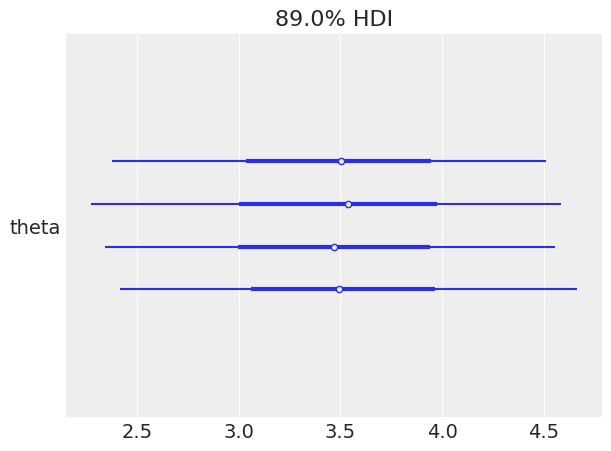

In [24]:
az.plot_forest(idata,
               hdi_prob=0.89)

Cada línea azul representa una cadena diferente y los puntos marcan la **media posterior** estimada para cada una. 

* Si todas las líneas están alineadas y centradas aproximadamente en el mismo rango, eso indica que _todas las cadenas convergieron al mismo resultado_ una señal de muestreo estable y confiable.

* El rango horizontal de cada barra corresponde al _intervalo donde se concentra el 89% más probable de los valores muestreados para $\theta$._

Podemos graficar la posterior con kde:

<Axes: title={'center': 'theta'}>

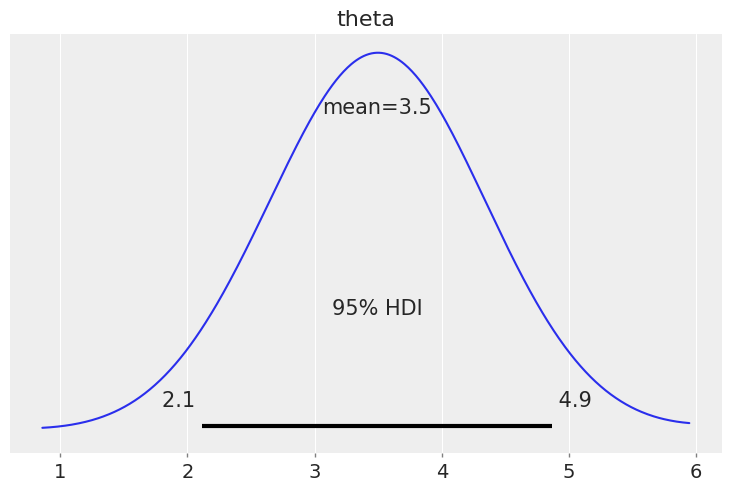

In [25]:
az.plot_posterior(idata,
                  hdi_prob=0.95,
                  bw=0.5) #bandwidth

>💡 En otras palabras:  
> No vemos la distribución posterior directamente,  
> pero la reconstruimos **a partir de un gran número de muestras** que la representan.

In [26]:
idata.posterior["theta"].sel(chain=1).to_pandas()

draw
0       4.779173
1       4.231161
2       2.145016
3       2.026315
4       5.509368
          ...   
1995    2.655475
1996    2.546124
1997    3.743327
1998    2.220272
1999    3.706945
Name: theta, Length: 2000, dtype: float64

## 4. Muestreo posterior predictivo

In [27]:
import warnings
warnings.filterwarnings("ignore", module="threadpoolctl")

* Cuando corremos `pm.sample()`, obtenemos una distribución posterior de los parámetros (ejem. $\theta =(\mu, \sigma$) que refleja lo que aprendimos de los datos observados.

esta posterior nos dice:

> Dado lo que observé, estos valores de $\mu$ y $\sigma$ son los más probables.

* Ahora, queremos evaluar el modelo. Con el **muestreo posterior predictivo**

Sirve para responder preguntas como:

> Si el modelo fuera cierto y estos parámetros fueran los correctos, ¿qué datos nuevos generaría?

**Entonces, usamos los parámetros muestreados de la posterior para simular nuevos datos a partir del mismo modelo probabilístico.**

#### Ejemplo 2: Nuevo modelo, incluyendo previa para la desviación estándar

In [28]:
data = rng.standard_normal(100)

with pm.Model() as model:
    # Previas
    mu = pm.Normal("mu",
                   mu=0,
                   sigma=1)
    
    sd = pm.HalfNormal("sd",
                       sigma=1)

    # Verosimilitud
    obs = pm.Normal("obs",
                    mu=mu,
                    sigma=sd,
                    observed=data)
    
    # Muestreo de las distribuciones posteriores
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


PyMC nos permite hacer esto automáticamente con la función `pm.sample_posterior_predictive()`. 

Esta función toma las muestras de la posterior (`idata`) y genera **nuevas observaciones simuladas** $\tilde{y}$ según los valores de parámetros que obtuvimos durante el muestreo.

In [29]:
# Incluimos muestras de la posterior predictiva
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [obs]


Output()

In [30]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

``posterior_predictive``: guarda las simulaciones de datos nuevos generadas a partir
de los parámetros muestreados.

* ``plot_pcc``**: visualización de la posterior predictiva**

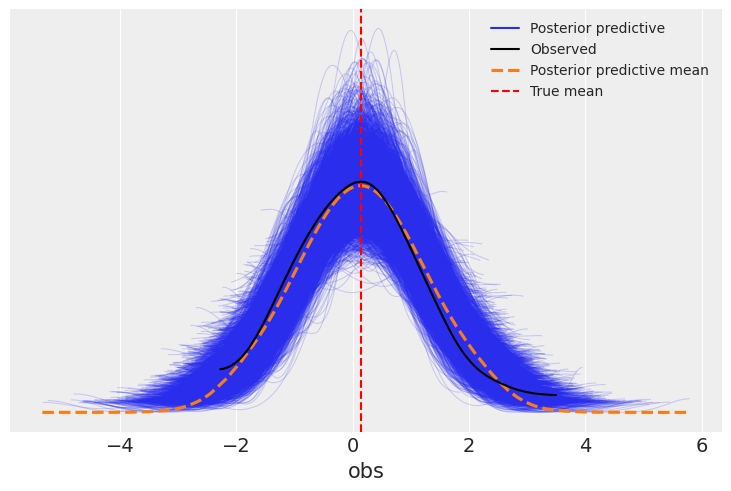

In [31]:
# Gráfica de las muestras de la posterior predictiva, la media de dichas muestras
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(data.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10)

| Elemento visual | Representa | Interpretación |
|------------------|-------------|----------------|
| **Líneas azules finas** | Muestras de la **posterior predictiva** | Cada curva azul es una simulación de posibles datos según el modelo; muestra la variabilidad esperada. |
| **Línea negra** | **Distribución observada** | Representa los datos reales que usamos para ajustar el modelo. |
| **Línea naranja discontinua** | **Media de las simulaciones** | Promedio de todas las simulaciones; refleja lo que el modelo predice “en promedio”. |
| **Línea roja punteada** | **Media verdadera (True mean)** | Valor real usado para generar los datos, sirve como referencia para evaluar el ajuste. |


In [32]:
# 1) Diagnósticos de muestreo
az.summary(idata, var_names=["mu", "sd"], hdi_prob=0.95)

# 2) Intervalos de credibilidad (numéricos)
# 2a) Parámetros
hdi_mu = az.hdi(idata.posterior["mu"], hdi_prob=0.95).to_array().values.squeeze()
hdi_sd = az.hdi(idata.posterior["sd"], hdi_prob=0.95).to_array().values.squeeze()
print("HDI 95% mu:", hdi_mu)
print("HDI 95% sd:", hdi_sd)

# 2b) Posterior predictiva (distribución de valores simulados)
ppc_flat = idata.posterior_predictive["obs"].values.reshape(-1)
hdi_ppc = az.hdi(ppc_flat, hdi_prob=0.95)
print("HDI 95% posterior predictiva (obs simuladas):", hdi_ppc)

HDI 95% mu: [-0.06481971  0.35788051]
HDI 95% sd: [0.95553794 1.26401346]
HDI 95% posterior predictiva (obs simuladas): [-1.99969293  2.34309411]


> En un modelo de Machine Learning, esto sería "trampa" porque estaríamos usando los datos de entrenamiento para evaluar el modelo.

## 5. Predicciones sobre datos no vistos

En esta sección veremos cómo realizar predicciones con un modelo de regresión logística bayesiana en PyMC, utilizando la API moderna (``pm.Data`` y ``model.set_data``) disponible desde la ``versión 5.25.1.``.

#### Ejemplo 3: Predicciones sobre datos no vistos

* **1. Generación de datos simulados**

Creamos un conjunto de datos simple: una variable `x` normal estándar y una variable binaria `y` que vale 1 cuando ``x > 1``.

In [33]:
rng = np.random.default_rng(8927)

x = rng.standard_normal(100)
y = (x > 0).astype(int)

coords = {"idx": np.arange(len(x))}

In [34]:
x

array([-0.22264222,  1.32565874, -0.57097002,  0.6682492 ,  1.14538102,
        0.58734406, -0.05144329, -1.84504794, -0.30722036, -0.01176056,
        0.63543926,  0.11328912,  1.41879627,  0.79941587, -0.42757956,
        1.53468809, -2.22735876,  0.28241532, -1.12155038,  1.30086967,
        0.51274112, -1.06199319, -0.09822517,  0.38922566, -1.95535676,
        0.33735625,  0.47742834, -1.10327477, -0.49871424,  0.9157944 ,
       -0.63225154,  0.52343605,  0.38268978,  0.17817512, -0.75581839,
       -0.82961425,  0.54596355,  1.29121212,  0.49681212, -1.23673741,
       -1.02877567, -0.38786421, -0.16475099,  0.02794133,  1.49207391,
       -0.89280504, -0.40397156,  0.37053056,  0.18221169,  1.35578274,
        0.06602347, -1.14783586,  1.20631292,  0.29378664, -0.24608568,
        0.86234979,  0.93790114,  0.04664653, -1.18832372, -1.52583061,
        1.33826815,  0.39615042,  0.26957478, -0.26209802,  0.54821982,
        0.96664454,  0.44183477,  0.78746462,  0.01135201,  2.36

In [35]:
y

array([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1])

In [36]:
coords

{'idx': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])}

* **2. Definición del modelo**

1. **Prior sobre el coeficiente (conocimiento previo):**

$$
\text{coeff} \sim \mathcal{N}(0, 1)
$$

2. **Función de enlace logística (para transformar valores reales en probabilidades):**

$$
p_i = \sigma(\text{coeff} \times x_i) = \frac{1}{1 + e^{-(\text{coeff} \times x_i)}}
$$

3. **Verosimilitud (modelo de generación de los datos observados):**

$$
y_i \sim \text{Bernoulli}(p_i)
$$

4. **Objetivo de la inferencia (distribución posterior):**

$$
p(\text{coeff} \mid x, y) \propto p(y \mid x, \text{coeff}) \, p(\text{coeff})
$$


In [37]:
with pm.Model(coords=coords) as model:
    # Datos mutables
    x_obs = pm.Data("x_obs", x, dims="idx") 
    y_obs = pm.Data("y_obs", y, dims="idx")

    # Modelo de regresión logística
    ## Conocimiento sobre la distribución previa del coeficiente
    coeff = pm.Normal("x",
                      mu=0,
                      sigma=1)
    
    ## La función sigmoide para obtener probabilidades
    logistic = pm.Deterministic("p", pm.math.sigmoid(coeff * x_obs), dims="idx")
    
    ## Una distribución bernoulli para los datos observados
    y_like = pm.Bernoulli("obs", 
                          p=logistic, 
                          observed=y_obs, #*** siempre que veamos "observed=", es una verosimilitud
                          dims="idx")

    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


> * `pm.Data` crea contenedores mutables que permiten reemplazar los datos sin reconstruir el modelo.
> * `pm.Deterministic` almacena la probabilidad estimada para cada observación.
> * `pm.Bernoulli` define el modelo generativo binario.

* **3. Predicciones en datos nuevos**

Supongamos que queremos predecir sobre tres nuevos valores de `x`:

**Qué representan esos tres valores**

- `x = -1.0`: está en la zona **negativa**, donde esperamos que la probabilidad de `y = 1` sea **baja** (cercana a 0).  

- `x = 0.0`: está **justo en el límite**, donde la probabilidad debería ser **cercana a 0.5**.  

- `x = 1.0`: está en la zona **positiva**, donde la probabilidad debería ser **alta** (cercana a 1).  


In [38]:
# nuevos datos
x_new = np.array([-1.0, 0.0, 1.0])
y_new = np.array([0, 0, 0])
coords_new = {"idx": np.array([1001, 1002, 1003])}

with model:
    # actualizamos los datos observados y las coordenadas
    model.set_data("x_obs", x_new, coords=coords_new)
    model.set_data("y_obs", y_new)

    # posterior predictiva para las nuevas observaciones
    ppc = pm.sample_posterior_predictive(
        idata, var_names=["p", "obs"], random_seed=8927
    ) # ***

# guardar estas predicciones dentro de idata original
idata.extend(ppc)

Sampling: [obs]


Output()

* **4. Análisis de resultados**

Calculamos la probabilidad promedio predicha por el modelo para cada nuevo punto:

In [39]:
idata.posterior_predictive["obs"].mean(dim=["draw","chain"])

<xarray.DataArray 'obs' (idx: 3)> Size: 24B
array([0.02575, 0.5015 , 0.973  ])
Coordinates:
  * idx      (idx) int64 24B 1001 1002 1003

* **5. Interpretación de los resultados**

En el paso anterior calculamos la probabilidad promedio de $y=1$ para cada nuevo valor de `x_new`, promediando sobre todas las cadenas y muestras de la posterior.

x_new | $P(y=1)$ estimada |
------|------------------|
$-1$   | $0.02625 $          |
$0$   | $0.5015 $             |
$1$   | $0.97225 $            |

Si aplicamos un umbral de decisión de $0.5$, las clases predichas sería ``[0,1,1]``.